1. 환경 & 라이브러리

In [ ]:
import os
# 렌더링을 GPU 없이 headless로 하기 위한 설정 (주피터/리눅스 서버에서 필수)
os.environ['MUJOCO_GL'] = 'egl'

import mujoco
import mediapy as media
import matplotlib.pyplot as plt

2. XML 정의

In [ ]:
xml = """
<mujoco model="simple_pendulum">
    <option gravity="0 0 -9.81" timestep="0.01" integrator="RK4"/>

    <!-- 장면 배경 흐림 효과 -->
    <visual>
        <rgba haze="1 1 1 1"/>
    </visual>

    <worldbody>
        <!-- 위에서 아래로 비추는 조명 -->
        <light diffuse=".5 .5 .5" pos="0 0 3" dir="0 0 -1"/>

        <!-- 시점을 고정하는 카메라 -->
        <camera name="track" mode="fixed" pos="0 -3.5 2.2" xyaxes="1 0 0 0 1 2"/>

        <!-- 펜듈럼 고정점 -->
        <body name="anchor" pos="0 0 1.5">
            <geom type="sphere" size="0.05" rgba=".2 .2 .2 1"/>

            <!-- 실제 pendulum body -->
            <body name="pole" pos="0 0 0">
                <!-- 회전 조인트 -->
                <joint name="swing_hinge" type="hinge" axis="0 1 0" damping="0.7"/>

                <!-- 아래로 길게 이어지는 막대 -->
                <geom name="pole_geom" type="capsule"
                        fromto="0 0 0 0 0 -1.0"
                        size="0.045" rgba="0.9 0.2 0.2 1"/>
            </body>
        </body>
    </worldbody>
</mujoco>
"""

3. 유틸 함수들

In [ ]:
def record_frame_and_data(renderer, data, frames_list, times_list, positions_list,
                          velocities_list, camera_name="track"):
    """
    현재 MuJoCo 상태를 이미지 + 상태벡터로 기록한다.
    renderer.update_scene --> 장면 업데이트
    renderer.render()     --> RGB 이미지 획득
    """
    renderer.update_scene(data, camera=camera_name)
    pixels = renderer.render()

    frames_list.append(pixels)
    times_list.append(float(data.time))
    positions_list.append(float(data.qpos[0]))   # hinge joint angle
    velocities_list.append(float(data.qvel[0]))  # hinge joint angular velocity


def simulate_pendulum(xml, duration=10.0, framerate=60, theta0=0.5):
    """
    pendulum을 duration 동안 시뮬레이션한다.
    
    - mj_step() 사용: 물리 시뮬레이션 시간에 따라 진행
    - mj_forward()는 단순 계산(정적 업데이트) 용도
    - theta0 : 초기 각도 (rad)
    """
    model = mujoco.MjModel.from_xml_string(xml)
    data = mujoco.MjData(model)
    renderer = mujoco.Renderer(model, height=480, width=640)

    frames, times, positions, velocities = [], [], [], []

    # 초기 각도 설정
    data.qpos[0] = theta0  

    # 시뮬레이션 루프 (MuJoCo 내부 timestep 기반)
    while data.time < duration:
        mujoco.mj_step(model, data)

        # 'fps * 시간' 기준으로 필요한 프레임 수 계산
        if len(frames) < data.time * framerate:
            record_frame_and_data(renderer, data, frames, times, positions, velocities)

    return frames, times, positions, velocities


def plot_results(times, positions, velocities):
    """펜듈럼 상태를 시각화 (단진자라 상태가 2개)"""
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle('Pendulum Position and Velocity over Time', fontsize=16)

    axs[0].plot(times, positions, label='Angle')
    axs[0].set_title('Pendulum Position')
    axs[0].set_xlabel('Time [s]')
    axs[0].set_ylabel('Position [rad]')
    axs[0].grid(True)

    axs[1].plot(times, velocities, 'r', label='Angular velocity')
    axs[1].set_title('Velocity')
    axs[1].set_xlabel('Time [s]')
    axs[1].set_ylabel('Velocity [rad/s]')
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

4. 시뮬레이션 실행

Simulation finished. Plotting results...


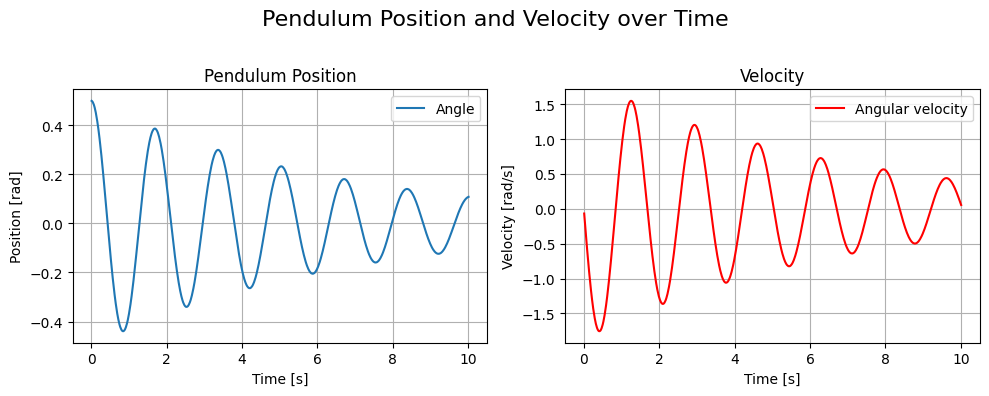

In [ ]:
duration = 10   # 10초 동안 시뮬레이션
framerate = 60  # 60 FPS로 영상 저장

frames, times, positions, velocities = simulate_pendulum(
    xml, duration=duration, framerate=framerate, theta0=0.5
)

print("Simulation finished. Plotting results...")
plot_results(times, positions, velocities)

5. 영상 출력

In [10]:
print("Rendering video...")
media.show_video(frames, fps=framerate)

Rendering video...
